# 公式ドキュメントの手法
周波数バンド: **変更**(YASAと同じ周波数バンド)
|name|frequency[Hz]|
|---|---|
|delta|1.0-4.0|
|theta|4.0-8.0|
|alpha|8.0-12.0|
|sigma|12.0-16.0|
|beta|16.0-30.0|

In [10]:
import numpy as np
import re
import mne
import yasa
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [11]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

### データの用意

ALICE: 訓練データ  
BOB: 推定対象データ  

In [12]:
# ここの0や1の数字を変えることで、対象データを変更
#  3 -> SC4031E0-PSG.edf
# 21 -> SC4211E0-PSG.edf
ALICE, BOB = 0, 27

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0],
                                stim_channel='Event marker',
                                misc=['Temp rectal'])

annot_train = mne.read_annotations(alice_files[1])

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### データの事前処理

In [13]:
# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)

raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(raw_train,
                                              event_id=annotation_desc_2_event_id,
                                              chunk_duration=30.)

tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train,
                          events=events_train,
                          event_id=event_id,
                          tmin=0.,
                          tmax=tmax,
                          baseline=None)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated


### 推定対象データにも同様に事前処理を行う

In [14]:
raw_test = mne.io.read_raw_edf(bob_files[0],
                               stim_channel='Event marker',
                               misc=['Temp rectal'])

annot_test = mne.read_annotations(bob_files[1])

annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)

raw_test.set_annotations(annot_test, emit_warning=False)

events_test, _ = mne.events_from_annotations(raw_test,
                                             event_id=annotation_desc_2_event_id,
                                             chunk_duration=30.)

epochs_test = mne.Epochs(raw=raw_test,
                         events=events_test,
                         event_id=event_id,
                         tmin=0.,
                         tmax=tmax,
                         baseline=None)

Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4271F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1052 matching events found
No baseline correction applied
0 projection items activated


### EEG信号から睡眠ステージを予測する関数の作成

In [15]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [1.0, 4.0],
                  "theta": [4.0, 8.0],
                  "alpha": [8.0, 12.0],
                  "sigma": [12.0, 16.0],
                  "beta": [16.0, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

### Scikit-Learnを使って睡眠ステージを予測する

In [16]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test) - 1

# Assess the results
y_test = epochs_test.events[:, 2] - 1


Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Loading data for 1052 events and 3000 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


0 bad epochs dropped
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


### 正解率の表示

In [17]:
acc = accuracy_score(y_test, y_pred)

print("正解率: {}".format(acc))

正解率: 0.2956273764258555


### ヒプノグラムの表示

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

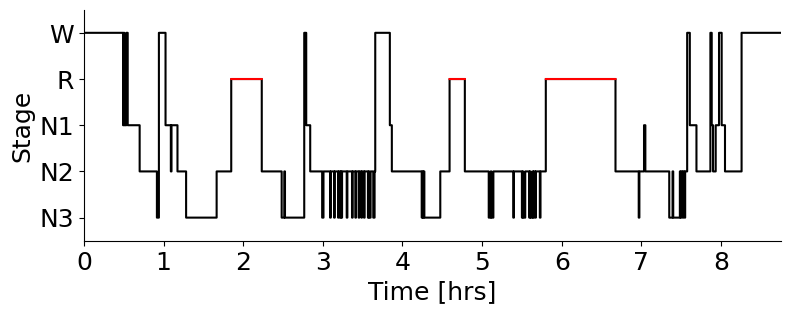

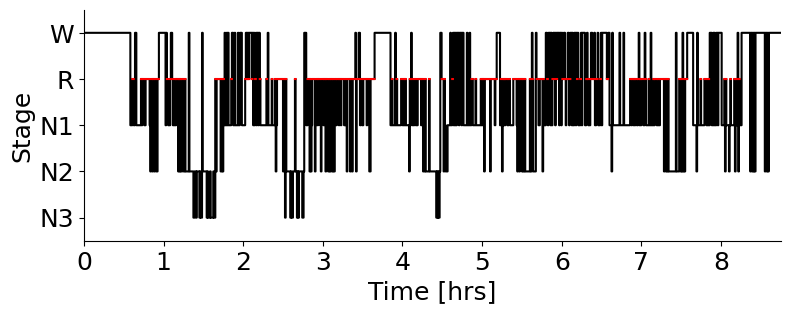

In [18]:
yasa.plot_hypnogram(y_test)
yasa.plot_hypnogram(y_pred)